In [81]:
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display,Image
from IPython.core.display import HTML 
from ipywidgets import Dropdown, Checkbox, Layout,GridBox

import pickle

BASE_URL = 'https://garden.org/'

In [2]:
with open('./final_df.pickle','rb') as file:
    df = pickle.load(file)

In [3]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    return train_test_split(dataset.drop(label_column, axis=1), dataset[label_column], test_size=test_ratio, random_state=rand_state)

## finding best model

### choosing right hyuper param and right algorithm for the job

In [4]:
def find_best_random_forest_num_estimators(X_train, y_train):
    parameters = {'n_estimators':[11,51,71] }
    clf = GridSearchCV(
        RandomForestClassifier(),
        parameters,
        scoring=make_scorer(metrics.f1_score))
    clf.fit(X_train, y_train)
    print("RandomForestClassifier best parameter set is:",clf.best_params_," and its score was",clf.best_score_)
    return clf.best_params_

def find_best_decision_tree_params(X_train, y_train):
    parameters = {'max_depth':[2,4,6], 'min_samples_split': [5,10,20] }
    clf = GridSearchCV(
        DecisionTreeClassifier(),
        parameters,
        scoring=make_scorer(metrics.f1_score))
    clf.fit(X_train, y_train)
    print("DecisionTreeClassifier best parameter set is:",clf.best_params_," and its score was",clf.best_score_)
    return clf.best_params_

def find_best_k_for_KNN(X_train, y_train):
    parameters = {'n_neighbors':[3,7,9,11] }
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters,scoring=make_scorer(f1_score))
    clf.fit(X_train, y_train)
    print("KNeighborsClassifier best parameter set is:",clf.best_params_," and its score was",clf.best_score_)
    return clf.best_params_

In [5]:
def find_best_model(X_train, y_train):
    dtc = DecisionTreeClassifier(**find_best_decision_tree_params(X_train, y_train))
    rfc = RandomForestClassifier(**find_best_random_forest_num_estimators(X_train, y_train))
    knnc = KNeighborsClassifier(**find_best_k_for_KNN(X_train, y_train))
    svc = SVC()
    scores_all = []
    for inx, cls in enumerate([dtc, rfc, knnc, svc]):
        scores = cross_val_score(cls, X_train, y_train, scoring=make_scorer(recall_score),
                        cv=10)
        average_score = np.average(scores)
        print(average_score)
        scores_all.append((cls, average_score))
    return sorted(scores_all,key=lambda x: x[1], reverse=True)[0]

In [6]:
def rebase_df(df, col_name):
    falsedf = df[df[col_name] == False]
    truedf = df[df[col_name] == True]
    if truedf.shape[0] * 2 < falsedf.shape[0]:
        return pd.concat([falsedf.sample(truedf.shape[0] * 2), truedf])
    else:
        return df

## fill all empty numeric values

### such as height, with values similar to other plants with the similar name

In [7]:
filled_df = df.copy()
for numeric_col in list(filled_df.select_dtypes(include=np.number).columns):
    filled_df[numeric_col] = filled_df.sort_values(by=['name'])[numeric_col].fillna(method='ffill')
filled_df = filled_df.drop(columns=['name', 'img']+ list(filled_df.select_dtypes(include=np.number).columns))

## options for features to predict

### only ones with more then 1000 true values

In [8]:
count_df = df.select_dtypes(include=np.bool)
for col in count_df.columns:
    if count_df[col].value_counts()[True] < 1000:
        count_df = count_df.drop(columns=[col])

<ipython-input-8-16c357e74f3e>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  count_df = df.select_dtypes(include=np.bool)


GridBox(children=(Checkbox(value=False, description='plant habit_cactus/succulent'), Checkbox(value=False, des…

Dropdown(description='feature:', options=('plant habit_cactus/succulent', 'plant habit_herb/forb', 'plant habi…

DecisionTreeClassifier best parameter set is: {'max_depth': 6, 'min_samples_split': 5}  and its score was 0.9455171649769761
RandomForestClassifier best parameter set is: {'n_estimators': 71}  and its score was 0.9705067366911647
KNeighborsClassifier best parameter set is: {'n_neighbors': 3}  and its score was 0.9617605935062077
0.9372143452877397
0.9608924103419516
0.9508590492076732
0.9654378648874063


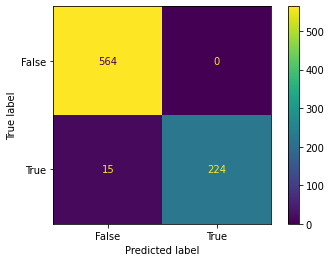

The model predicted that your plant is True for uses_medicinal herb


In [115]:
widget = Dropdown(
    options=count_df.columns,
    description='predict:',
    disabled=False
)

feature_widgets = []
feature_input_options = ('plant habit', 'life cycle', 'flowers','sun requirements','leaves','wildlife attractant','water preferences','flower color','flower time','pollinators','edible parts')
all_boolean_features = list(filter(lambda cn: cn.startswith(feature_input_options), filled_df.columns))
for feature in all_boolean_features:
    feature_widgets.append(Checkbox(
    value=False,
    description=feature,
    disabled=False,
    ))
box = GridBox(children=feature_widgets, layout=Layout(
            width='50%'))


def on_change(feature_name):
    
    valid_cols = list(filter(lambda cn: feature_name.split('_')[0] not in cn, filled_df.columns))
    min_cols = list(filter(lambda cn: cn.startswith(feature_input_options), valid_cols))
    valid_cols_df = filled_df[min_cols + [feature_name]]
    
    X_train, X_test, y_train, y_test = split_to_train_and_test(rebase_df(valid_cols_df, feature_name), feature_name, 0.2, 42)
    z = find_best_model(X_train, y_train)
    clf = z[0]
    clf.fit(X_train, y_train)
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()
    record_to_predict = pd.DataFrame({c.description: c.value for c in box.children}, index=[0])
    print("The model predicted that your plant is %s for %s" % (clf.predict(record_to_predict[min_cols])[0], feature_name))


widget.observe(
    lambda c: on_change(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)

display(box)
display(widget)

In [114]:
filled_df[all_boolean_features + ['uses_medicinal herb']].corr()['uses_medicinal herb'].nlargest(10)

uses_medicinal herb                  1.000000
leaves_fragrant                      0.450269
leaves_malodorous                    0.307539
edible parts_leaves                  0.229073
edible parts_seeds or nuts           0.217817
pollinators_bees                     0.181170
edible parts_flowers                 0.175650
water preferences_dry mesic          0.146165
wildlife attractant_birds            0.127868
pollinators_moths and butterflies    0.126248
Name: uses_medicinal herb, dtype: float64